# Introduction

New York City Taxi Trip Duration

https://www.kaggle.com/c/nyc-taxi-trip-duration
In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

Longtime Kagglers will recognize that this competition objective is similar to the ECML/PKDD trip time challenge we hosted in 2015. But, this challenge comes with a twist. Instead of awarding prizes to the top finishers on the leaderboard, this playground competition was created to reward collaboration and collective learning.

We are encouraging you (with cash prizes!) to publish additional training data that other participants can use for their predictions. We also have designated bi-weekly and final prizes to reward authors of kernels that are particularly insightful or valuable to the community.

# 1. Data Pre-processing

## 1.1 Import Libraries

In [1]:
library(data.table) # for fast data processing
library(ggplot2) #data visualization
library(ggthemes) # visualization themes
library(ggmap)
library(rworldmap)
library(raster) #library with info over US counties
library(dplyr) # data manipulation
library(RColorBrewer)
library(lubridate)
library(chron) #handling of dates
library(geosphere)
library(RColorBrewer)

Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'ggthemes' was built under R version 3.3.3"Warning message:
"package 'ggmap' was built under R version 3.3.3"Warning message:
"package 'rworldmap' was built under R version 3.3.3"Loading required package: sp
### Welcome to rworldmap ###
For a short introduction type : 	 vignette('rworldmap')
Warning message:
"package 'raster' was built under R version 3.3.3"
Attaching package: 'raster'

The following object is masked from 'package:data.table':

    shift

------------------------------------------------------------------------------
data.table + dplyr code now lives in dtplyr.
Please library(dtplyr)!
------------------------------------------------------------------------------

Attaching package: 'dplyr'

The following objects are masked from 'package:raster':

    intersect, select, union

The following objects are masked from 'package:data.table':

    between, first, last

The following ob

## 1.2 Helper Functions

In [2]:
library(grid)
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  plots <- c(list(...), plotlist)
  numPlots = length(plots)
  if (is.null(layout)) {
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)), ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])
  } else {
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    for (i in 1:numPlots) {
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,layout.pos.col = matchidx$col))
    }
  }
}

## 1.3 Load train/test data
Data will be stored in test/train variables and stored in a data.table format

In [3]:
train <- fread('C:/datasets/NYCtaxi_train.csv', sep=",", stringsAsFactors=F)
test <- fread('C:/datasets/NYCtaxi_test.csv', sep=",", stringsAsFactors=F)

Read 1458644 rows and 11 (of 11) columns from 0.187 GB file in 00:00:23
Read 625134 rows and 9 (of 9) columns from 0.066 GB file in 00:00:08


## 1.4 Summary of test and train variables

In [20]:
str(train)

Classes 'data.table' and 'data.frame':	1458644 obs. of  11 variables:
 $ id                : chr  "id2875421" "id2377394" "id3858529" "id3504673" ...
 $ vendor_id         : int  2 1 2 2 2 2 1 2 1 2 ...
 $ pickup_datetime   : chr  "2016-03-14 17:24:55" "2016-06-12 00:43:35" "2016-01-19 11:35:24" "2016-04-06 19:32:31" ...
 $ dropoff_datetime  : chr  "2016-03-14 17:32:30" "2016-06-12 00:54:38" "2016-01-19 12:10:48" "2016-04-06 19:39:40" ...
 $ passenger_count   : int  1 1 1 1 1 6 4 1 1 1 ...
 $ pickup_longitude  : num  -74 -74 -74 -74 -74 ...
 $ pickup_latitude   : num  40.8 40.7 40.8 40.7 40.8 ...
 $ dropoff_longitude : num  -74 -74 -74 -74 -74 ...
 $ dropoff_latitude  : num  40.8 40.7 40.7 40.7 40.8 ...
 $ store_and_fwd_flag: chr  "N" "N" "N" "N" ...
 $ trip_duration     : int  455 663 2124 429 435 443 341 1551 255 1225 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [6]:
str(test)

Classes 'data.table' and 'data.frame':	625134 obs. of  9 variables:
 $ id                : chr  "id3004672" "id3505355" "id1217141" "id2150126" ...
 $ vendor_id         : int  1 1 1 2 1 1 1 1 2 2 ...
 $ pickup_datetime   : chr  "2016-06-30 23:59:58" "2016-06-30 23:59:53" "2016-06-30 23:59:47" "2016-06-30 23:59:41" ...
 $ passenger_count   : int  1 1 1 1 1 1 1 2 2 1 ...
 $ pickup_longitude  : num  -74 -74 -74 -74 -74 ...
 $ pickup_latitude   : num  40.7 40.7 40.7 40.8 40.8 ...
 $ dropoff_longitude : num  -74 -74 -74 -74 -74 ...
 $ dropoff_latitude  : num  40.8 40.7 40.7 40.7 40.8 ...
 $ store_and_fwd_flag: chr  "N" "N" "N" "N" ...
 - attr(*, ".internal.selfref")=<externalptr> 


# 2 Selection of relevan features

## 2.1 Select features and apply variable type format 


| No. |Variable|Description|Format|Keep/Discard|
|--|--|--|--|--|
|1| id | unique identifier for each trip| None | Discard - Not relevant |
|2|vendor_id | Company ID of the service provider| factor | Keep - differentiate among taxi companies|
|3|pickup_datetime | date and time when the meter was engaged | Date (POSIXct) | Keep |
|4|dropoff_datetime | date and time when the meter was disengaged | None | Discard - It becomes redundant with trip_duration|
|5|passenger_count | number of passengers in the vehicle | factor |Keep - Passenger volume estimation|
|6|pickup_longitude  | the longitude where the meter was engaged | factor | Keep - Location Geoinformation|
|7|pickup_latitude   | the latitude where the meter was engaged | numeric | Keep - Location Geoinformation|
|8|dropoff_longitude | the longitude where the meter was disengaged | numeric | Keep - Location Geoinformation|
|9|dropoff_latitude  | the latitude where the meter was disengaged | numeric | keep - Location Geoinformation|
|10|store_and_fwd_flag | Indicates if the record was held in vehicle waiting for connection | None |Discard Not relevant for analysis|
|11|trip_duration  | duration of the trip in seconds | numeric |Keep - Target variable|


In [4]:
train <- train %>%
  mutate_at("vendor_id", funs(factor)) %>%
  mutate_at("passenger_count", funs(as.factor)) %>% 
  mutate_at("pickup_datetime", funs(as.POSIXct(., tz="Etc/GMT-5")))%>%
  mutate( dataset = rep("train",nrow(train))) %>%
  dplyr::select(pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,
                dropoff_longitude,dropoff_latitude,trip_duration,dataset)

test <- test %>%
  mutate_at("vendor_id", funs(factor)) %>%
  mutate_at("passenger_count", funs(as.factor)) %>% 
  mutate_at("pickup_datetime", funs(as.POSIXct(., tz="Etc/GMT-5"))) %>%
  mutate(trip_duration = rep(NA,nrow(test)),
               dataset = rep("test",nrow(test))) %>%
  dplyr::select(pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,
                dropoff_longitude,dropoff_latitude,trip_duration,dataset)

data <- rbind(train,test)

In [117]:
str(train)

'data.frame':	1458644 obs. of  8 variables:
 $ pickup_datetime  : chr  "2016-03-14 17:24:55" "2016-06-12 00:43:35" "2016-01-19 11:35:24" "2016-04-06 19:32:31" ...
 $ passenger_count  : Factor w/ 10 levels "0","1","2","3",..: 2 2 2 2 2 7 5 2 2 2 ...
 $ pickup_longitude : num  -74 -74 -74 -74 -74 ...
 $ pickup_latitude  : num  40.8 40.7 40.8 40.7 40.8 ...
 $ dropoff_longitude: num  -74 -74 -74 -74 -74 ...
 $ dropoff_latitude : num  40.8 40.7 40.7 40.7 40.8 ...
 $ trip_duration    : int  455 663 2124 429 435 443 341 1551 255 1225 ...
 $ dataset          : chr  "train" "train" "train" "train" ...


In [21]:
## RUN THIS CELL TO FILTER ROWS FOR TESTING PURPOSES
data <- sample_n(data, 100000)

##  2.2 Handling Missing Values
Fortunately the dataset does not have any missing values. However it is far from "clean". Data issues will be addressed in the comming sections

In [31]:
sum(is.na(train))
sum(is.na(test[,1:7]))

[1] 0

[1] 0

# 3 Data Cleaning and Creation of new variables
 

## 3.1 trip_duration
Since trip duration is one of the most important features, we will start fixing all the inconsistencies on this datasets.

### 3.1.1 Unusually short rides

Short taxi rides are not representative of what a typical trip in new york represents. The median ride in NYC is in the realm of 11 minutes. Observations with less than 60 seconds, wont allow the passengers to get into the car, give their greetings and directions to the driver. The reason for these observations could be caused by the operator by starting the meter by mistake of by clients cancelling trips requests on the spot. 

The graph on the left shows all the observations under the 200 second mark. There are ~8600 observations on the train dataset with trip duration under the 60 seconds mark. These records constitute 0.59 % of the total observations on the train dataset. Since these observations does not represent a typical behaviour, they will be completely removed from the train dataset.

It is interesting how removing these observations the curve observed at the left of the 60 sec marks disappears and on the left side a linear increaseing pattern can be seen.

[1] "Observations on data (before processsing): 2077700"
[1] "Observations under 50 sec: 0"
[1] "% of obs that will be deleted from dataset 0 %"
[1] "Observations on data (after processsing): 2077700"


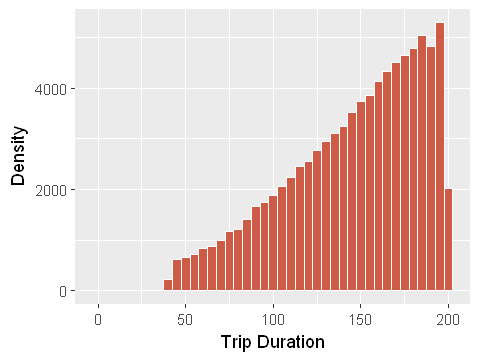

In [6]:
shortRides <- data %>%  
    filter( trip_duration < 200 & dataset == "train")%>%  
    dplyr::select(trip_duration)%>%  
    mutate(short_trips = as.factor((trip_duration < 40)*1))  

options(repr.plot.width=4, repr.plot.height=3) #Graph sizing in jupyter,for rstudio is not required

ggplot(shortRides, aes(x=trip_duration,,fill=trip_duration >= 40)) + 
    geom_histogram(colour = "white",  binwidth = 5) +  
    scale_fill_manual(values = c("coral3", "darkgray")) +
    theme(legend.position = "none", axis.title = element_text(size=10.5)) +
    labs(x = "Trip Duration", y = "Density") +
    expand_limits(x = 0)

abnormal_obs <- count(data %>% filter( trip_duration < 40))$n

print(paste("Observations on data (before processsing):",nrow(data)))
print(paste("Observations under 50 sec:",abnormal_obs))
print(paste("% of obs that will be deleted from dataset", round(abnormal_obs*100/nrow(data),2),"%") )

data <- data %>% 
     filter( trip_duration > 40 | dataset == "test")

print(paste("Observations on data (after processsing):",nrow(data)))

### 3.1.2 Unusually long rides

Figure 3.2a shows a histogram of trip_duration. the fact that there are a few, but highly misleading observations makes the gross of the population to be unnoticable. As an example there is a recorded trip that lasted 979.5 hours. That was quite a journey. These kind of observations are probably caused by errors in the logging system or drivers that leave the meter running without paying attention. Based on our business case we are interested only on the trips which fall in what is consider normal for a NYC taxi trip.

Based on a numerical analysis it can be derived that 99.57 of the taxi rides fall under the 1.2 hour trip duration. Only 6233 observations go over this mark. These observations will be deleted from the dataset since they do not help our analysis. Deleting these items lowers our average taxi trip from 16.09 to 13.83 which is a considerable difference given the size of the population.

The histogram in Figure 3.2b which doesnt account for outliers and trips longer than 1h 12m shows a normal distribution (although positively skewed). 

[1] "Observations on data (before processsing): 2077700"
[1] "Max trip duration 979.52 hrs"
[1] "Avg 16.06 mins"
[1] "# of Long Trips (> 45 minutes) 34101"
[1] "% of obs that will be deleted from data 1.64 %"


Warning message:
"Removed 625134 rows containing non-finite values (stat_bin)."

[1] "Avg after removing outliers: 13.01 mins"
[1] "Observations on data (after processsing): 2043563"


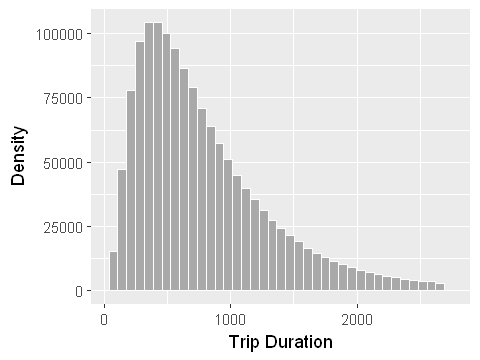

In [7]:
print(paste("Observations on data (before processsing):",nrow(data)))
print(paste("Max trip duration",round(max((data %>% filter(dataset=="train"))$trip_duration)/3600,2),"hrs"))
print(paste("Avg",round(mean((data %>% filter(dataset=="train"))$trip_duration)/60,2),"mins"))

abnormal_obs <- nrow(data %>% filter( trip_duration > .75*3600 ))
print(paste("# of Long Trips (> 45 minutes)",abnormal_obs))

print(paste("% of obs that will be deleted from data",round(abnormal_obs/nrow(data)*100,2),"%"))

data <- data %>% 
     filter( trip_duration < .75 *3600 | dataset == "test")

options(repr.plot.width=4, repr.plot.height=3) #Graph sizing in jupyter,for rstudio is not required

ggplot(data, aes(trip_duration)) + 
    theme(legend.position = "none",axis.title = element_text(size=10.5)) + 
    geom_histogram(colour = "white",  fill ="darkgray",binwidth = 70) + 
    labs(x = "Trip Duration", y = "Density") 

print(paste("Avg after removing outliers:",round(mean((data %>% filter(dataset=="train"))$trip_duration)/60,2),"mins"))
print(paste("Observations on data (after processsing):",nrow(data)))

## 3.2 Coordinates
The coordinates provided in this dataset are the main features that we will use in order to make our analysis.The following are the mos important issues that will be solved

### 3.2.1 Coordinates outside the business focus area

Based on the train at test datasets it can be seen that there are some pickup/dropoff location outside new york. There are coordinates that point to places as far as California which is 5000 km away. There are also a few interstate locations and even some taxi rides to the middle of the Atlantic ocean which are clearly outliers as is shown in Figures 3.1a/b.
To avoid this issues only observations with pickup, dropoff corrdinates in these counties will be considered:
* New York
* Queens
* Kings
* Bronx
* Hudson

The handling of values outside this counties will be handled in the following sections

### 3.2.1 Classify observations by county
Classifying each observation by county will allow us to make a great variety of calculations within the county level.

In [8]:
allpoints <- data

# assign polygon map to an object:
NYJ <- getData("GADM",country="USA",level=2)
m <- NYJ[NYJ$NAME_1 %in% c('New York','New Jersey'),]

#Note: For selectig a whole contry the following dataset can be used to define m
# m = getMap(resolution="low")
# c = m[m$ISO_A2 == "IT",] #select Italy as a polygon in the map 

counties = c("New York","Queens","Kings","Bronx","Hudson")

In [9]:
### -------Pickup coordinates county feature generation ---------- ###

print(paste("Observations on data:",nrow(data)))

# convert coordinates from out dataset into Spatial Point Dataset object -- first longitude, then latitude:
pts <- SpatialPointsDataFrame(data[,c('pickup_longitude', 'pickup_latitude')], 
                              data[,c('pickup_datetime','passenger_count',
                                       'dropoff_longitude','dropoff_latitude','trip_duration','dataset')])

# assign CRS:
proj4string(pts) = proj4string(m)

#create a temporary dataframe
temp = data[0,c('pickup_datetime','passenger_count','dropoff_longitude','dropoff_latitude',
                'pickup_longitude','pickup_latitude','trip_duration','dataset')]

countyVector = vector()

#loop over the counties
for(i in counties){
    
    #subset the coordinates of county poligon of each county in m
    c <- m[m$NAME_2  == i,]
    
    #subset the points that lie on that poligon
    points <- pts[c,]
      
    #re-create the dataframe
    selected <-  data.frame(points@data, pickup_longitude= coordinates(points)[,1],  pickup_latitude= coordinates(points)[,2])

    #create the county variable
    countyVector <- c(countyVector,rep(i,nrow(selected)))
    
    #merge the dataset with the previous iterations
    temp <- rbind(temp,selected)
}

# recreate the data dataset and delete autogenerated row names
data <- data.frame(temp[,c('pickup_datetime','passenger_count','pickup_longitude','pickup_latitude')],
                         pickup_county=countyVector, temp[,c('dropoff_longitude','dropoff_latitude','trip_duration','dataset')])

row.names(data) <- NULL

print(paste("Observations on dataset:",nrow(temp)))

[1] "Observations on data: 2043563"
[1] "Observations on dataset: 2042487"


In [10]:
### -------Dropoff coordinates county feature generation ---------- ###

print(paste("Observations on data:",nrow(data)))

# convert coordinates from out dataset into Spatial Point Dataset object -- first longitude, then latitude:
pts <- SpatialPointsDataFrame(data[,c('dropoff_longitude', 'dropoff_latitude')], 
                              data[,c('pickup_datetime','passenger_count','pickup_longitude',
                                      'pickup_latitude','pickup_county','trip_duration','dataset')])

# assign CRS:
proj4string(pts) = proj4string(m)

#create a temporary dataframe
temp = data[0,c('pickup_datetime','passenger_count','pickup_longitude','pickup_latitude',
                'pickup_county','dropoff_longitude', 'dropoff_latitude','trip_duration','dataset')]

countyVector = vector()

#loop over the counties
for(i in counties){
    
    #subset the coordinates of county poligon of each county in m
    c <- m[m$NAME_2  == i,]
    
    #subset the points that lie on that poligon
    points <- pts[c,]
      
    #re-create the dataframe
    selected <-  data.frame(points@data, dropoff_longitude= coordinates(points)[,1],  dropoff_latitude= coordinates(points)[,2])

    #create the county variable
    countyVector <- c(countyVector,rep(i,nrow(selected)))
    
    #merge the dataset with the previous iterations
    temp <- rbind(temp,selected)
}

# recreate the data dataset and delete autogenerated row names
data <- data.frame(temp[,c('pickup_datetime','passenger_count','pickup_longitude',
                'pickup_latitude','pickup_county','dropoff_longitude','dropoff_latitude')],dropoff_county=countyVector,
                   temp[,c("trip_duration","dataset")])

row.names(data) <- NULL

print(paste("Observations on data:",nrow(temp)))


[1] "Observations on data: 2042487"
[1] "Observations on data: 2036765"


Map from URL : http://tile.stamen.com/toner-lite/4/2/5.png
Map from URL : http://tile.stamen.com/toner-lite/4/3/5.png
Map from URL : http://tile.stamen.com/toner-lite/4/4/5.png
Map from URL : http://tile.stamen.com/toner-lite/4/5/5.png
Map from URL : http://tile.stamen.com/toner-lite/4/2/6.png
Map from URL : http://tile.stamen.com/toner-lite/4/3/6.png
Map from URL : http://tile.stamen.com/toner-lite/4/4/6.png
Map from URL : http://tile.stamen.com/toner-lite/4/5/6.png
Warning message:
"Removed 2 rows containing missing values (geom_point)."

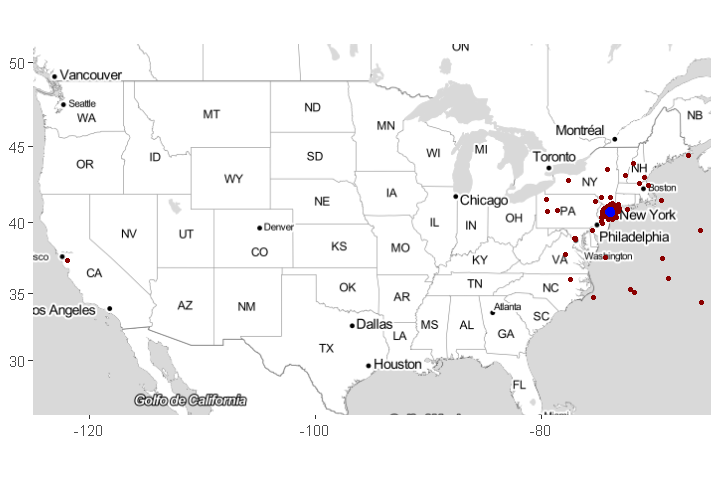

In [11]:
us <- c(left = -125, bottom = 25.75, right = -65, top = 51)
map <- get_stamenmap(us, zoom = 4, maptype = "toner-lite")

options(repr.plot.width= 6, repr.plot.height=4) #Graph sizing in jupyter,for rstudio is not required

ggmap(map) + 
geom_point(data = data.frame(lon = allpoints$pickup_longitude, lat = allpoints$pickup_latitude), 
                               mapping = aes(x = lon, y = lat), color = "darkred",size = 1) +
  geom_point(data = data.frame(lon = data$pickup_longitude, lat = data$pickup_latitude), 
                    mapping = aes(x = lon, y = lat), color = "blue",size = 1) +
                    theme(axis.title.x=element_blank(),axis.title.y=element_blank()) 


Fig 3.3 shows how all the coordinates that lied outside the area of interest, including the taxi rides to the oceans, have been exclluded of the dataset.m

Warning message:
"Removed 91 rows containing missing values (geom_point)."Warning message:
"Removed 1016 rows containing missing values (geom_point)."

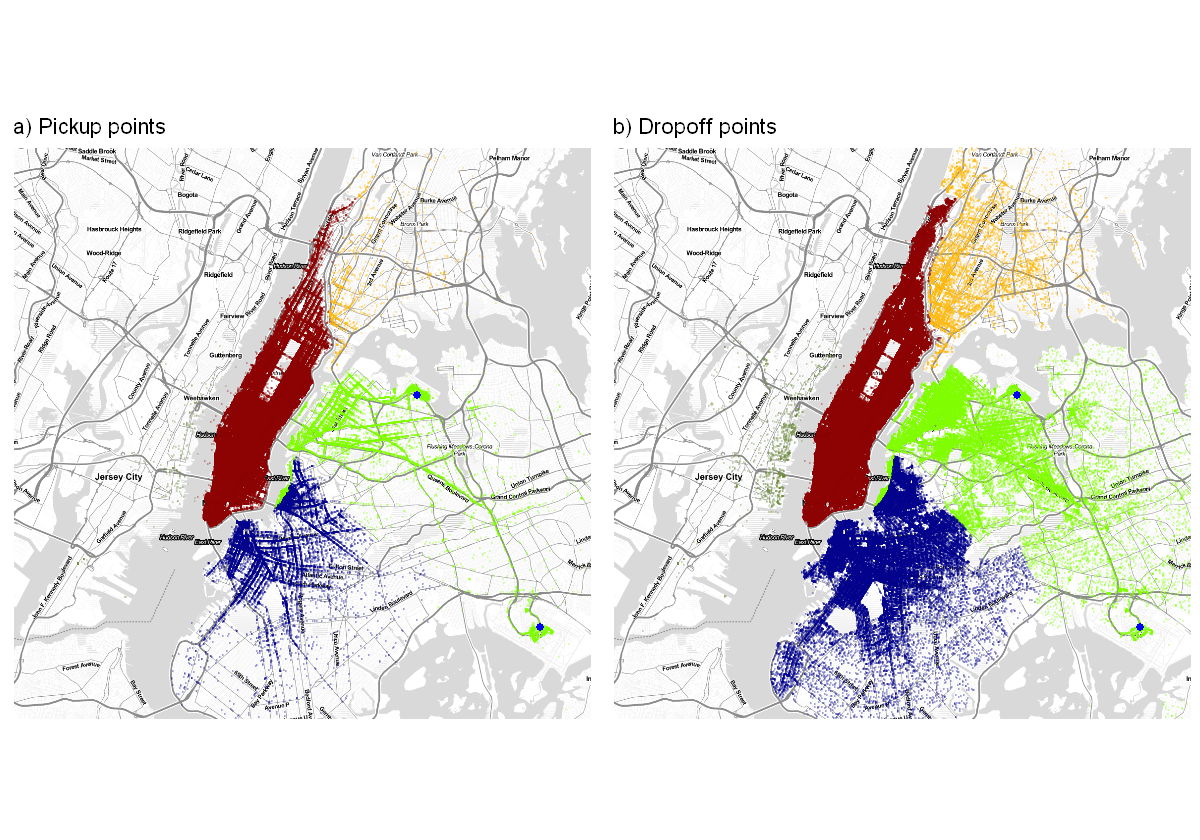

In [69]:
box <- c(left = -74.15, bottom = 40.60, right = -73.75, top = 40.9)
map <- get_stamenmap(box, zoom = 12, maptype = "toner-lite")

colors <- c("darkgoldenrod1","darkolivegreen4","darkblue","darkred","chartreuse" )

p1 <- ggmap(map) + 
    geom_point(aes(x = pickup_longitude, y = pickup_latitude, color=pickup_county), data = data, alpha = .2, size = .1) +
    scale_color_manual(values=colors) +
    geom_point(aes(x = lon, y = lat), data = data.frame( lon = c(-73.87,-73.785) ,lat = c(40.77,40.648)), alpha = 1, color="blue", size = 2)+
    theme(legend.position = "none", axis.title.x=element_blank(),axis.title.y=element_blank(),axis.ticks=element_blank(), axis.text.x=element_blank(), axis.text.y=element_blank(),axis.title = element_text(size=10)) +
    ggtitle("a) Pickup points")  

p2 <- ggmap(map) + 
    geom_point(aes(x = dropoff_longitude, y = dropoff_latitude,color=dropoff_county), data = data, alpha = .2, size = .1) +
    scale_color_manual(values=colors) +
    geom_point(aes(x = lon, y = lat), data = data.frame( lon = c(-73.87,-73.785) ,lat = c(40.77,40.648)), alpha = 1, color="blue", size = 2)+
    theme(legend.position = "none", axis.title.x=element_blank(),axis.title.y=element_blank(),axis.ticks=element_blank(), axis.text.x=element_blank(), axis.text.y=element_blank(),axis.title = element_text(size=10)) + 
    ggtitle("b) Dropoff points") 


options(repr.plot.width=10, repr.plot.height=7) #Graph sizing in jupyter,for rstudio is not required
layout <- matrix(c(1,2),1,2,byrow=TRUE)
multiplot(p1,p2, layout=layout)


### 3.2.1 Classify observations by neighborhood
https://www.kaggle.com/jackcook/incorporating-neighborhoods-into-your-model/notebook

In order to determine the neighborhoods of given locations, I made use of the publicly available Zillow Neighborhood Boundary Shapefiles. It's fairly easy to get started with these, despite the scariness that can be induced by non-plaintext files. For example, if you wanted to get a list of the names of all neighborhoods in New York City, it's fairly simple.

In [12]:
library(rgdal, quietly = TRUE, warn.conflicts = FALSE)

# Load the polygons on the from Zillow Neighborhood Boundary Shapefiles 
ny.map <- readOGR("c:/datasets/ZillowNeighborhoods-NY.shp", layer = "ZillowNeighborhoods-NY")
neighborhoods <- ny.map[ny.map$City == c("New York"), ]
neighborhood_names <- levels(neighborhoods$Name)

OGR data source with driver: ESRI Shapefile 
Source: "c:/datasets/ZillowNeighborhoods-NY.shp", layer: "ZillowNeighborhoods-NY"
with 579 features
It has 5 fields


In [13]:
# create a dataframe for pickup coordinates
dat <- data.frame(long = data["pickup_longitude"], lat = data["pickup_latitude"])

# set the data frame's coordinate and projection data so that the shapefile libraries know what to do with it.
coordinates(dat) <- ~ pickup_longitude + pickup_latitude
proj4string(dat) <- proj4string(neighborhoods)

# figure out which points overlap with which neighborhoods
data$pickup_neighborhood <- over(dat, neighborhoods)$Name
levels(data$pickup_neighborhood) <- c(levels(data$pickup_neighborhood), "New Jersey")
data$pickup_neighborhood[is.na(data$pickup_neighborhood)] <- "New Jersey"

# set the data frame's coordinate and projection data so that the shapefile libraries know what to do with it.
dat <- data.frame(long = data["dropoff_longitude"], lat = data["dropoff_latitude"])

# create a dataframe for dropoff coordinates
coordinates(dat) <- ~ dropoff_longitude + dropoff_latitude
proj4string(dat) <- proj4string(neighborhoods)

# figure out which points overlap with which neighborhoods
data$dropoff_neighborhood <- over(dat, neighborhoods)$Name
levels(data$dropoff_neighborhood) <- c(levels(data$dropoff_neighborhood), "New Jersey")
data$dropoff_neighborhood[is.na(data$dropoff_neighborhood)] <- "New Jersey"

Warning message:
"Removed 134 rows containing missing values (geom_point)."Warning message:
"Removed 2358 rows containing missing values (geom_point)."

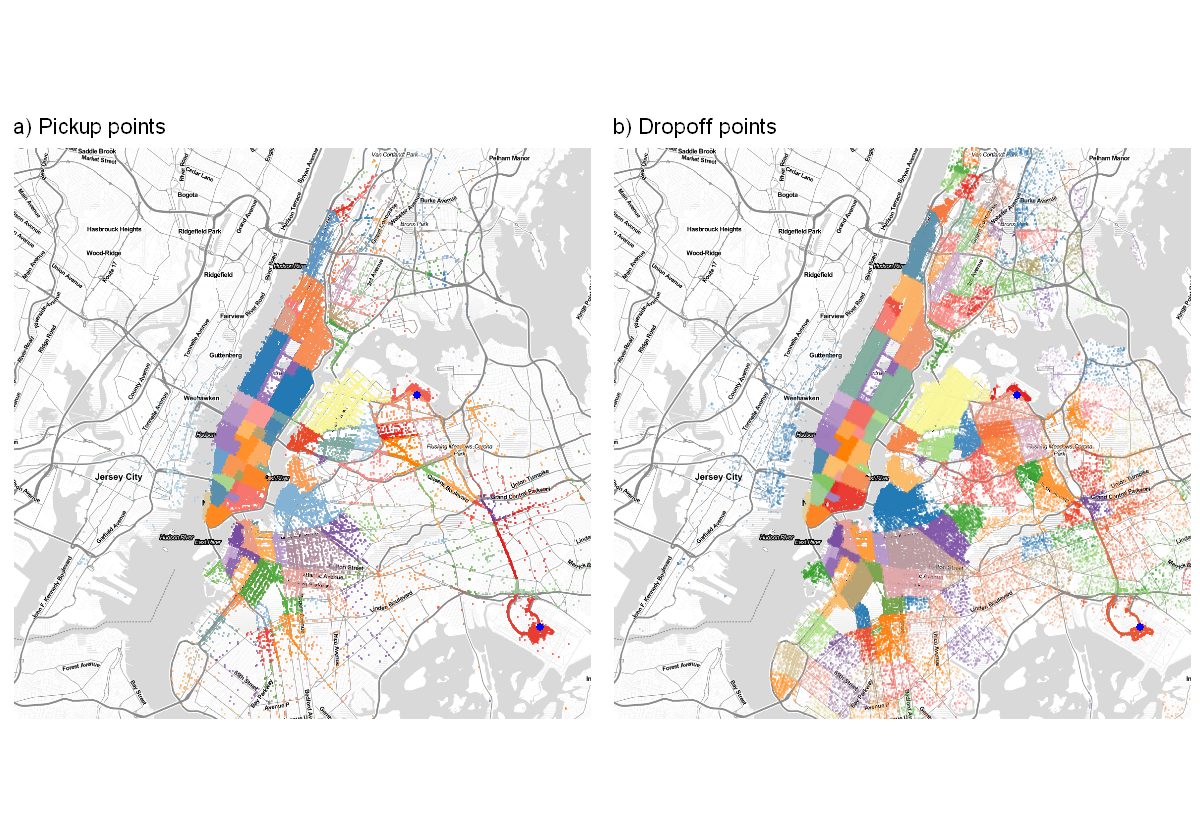

In [16]:
hm_palette <- colorRampPalette(rev(brewer.pal(11, 'Paired')), space='Lab')  

box <- c(left = -74.15, bottom = 40.60, right = -73.75, top = 40.9)
map <- get_stamenmap(box, zoom = 12, maptype = "toner-lite")

colors <- c("darkgoldenrod1","darkolivegreen4","darkblue","darkred","chartreuse" )

p1 <- ggmap(map) + 
    geom_point(aes(x = pickup_longitude, y = pickup_latitude, color=pickup_neighborhood), data = data, alpha = .5, size = .1) +
    scale_color_manual(values=hm_palette(194)) +
    geom_point(aes(x = lon, y = lat), data = data.frame( lon = c(-73.87,-73.785) ,lat = c(40.77,40.648)), alpha = 1, color="blue", size = 2)+
    theme(legend.position = "none", axis.title.x=element_blank(),axis.title.y=element_blank(),axis.ticks=element_blank(), axis.text.x=element_blank(), axis.text.y=element_blank(),axis.title = element_text(size=10)) +
    ggtitle("a) Pickup points")  

p2 <- ggmap(map) + 
    geom_point(aes(x = dropoff_longitude, y = dropoff_latitude,color=dropoff_neighborhood), data = data, alpha = .2, size = .1) +
    scale_color_manual(values=hm_palette(220)) +
    geom_point(aes(x = lon, y = lat), data = data.frame( lon = c(-73.87,-73.785) ,lat = c(40.77,40.648)), alpha = 1, color="blue", size = 2)+
    theme(legend.position = "none", axis.title.x=element_blank(),axis.title.y=element_blank(),axis.ticks=element_blank(), axis.text.x=element_blank(), axis.text.y=element_blank(),axis.title = element_text(size=10)) + 
    ggtitle("b) Dropoff points") 


options(repr.plot.width=10, repr.plot.height=7) #Graph sizing in jupyter,for rstudio is not required
layout <- matrix(c(1,2),1,2,byrow=TRUE)
multiplot(p1,p2, layout=layout)

## 3.3 Passenger Count

There are some ocurrences on which the passenger count is set up at 0. Since there cannot be a taxi trip without a client, we will set up the value of these observations to 1. There are X observations where the passenger count is equal to 8, it seems like an anomaly, but we will leave it as it for now.

[1] "Observations on data: 2036765"
[1] "# of observations with passenger_count=0: 38"
[1] "Observations on data: 1860410"


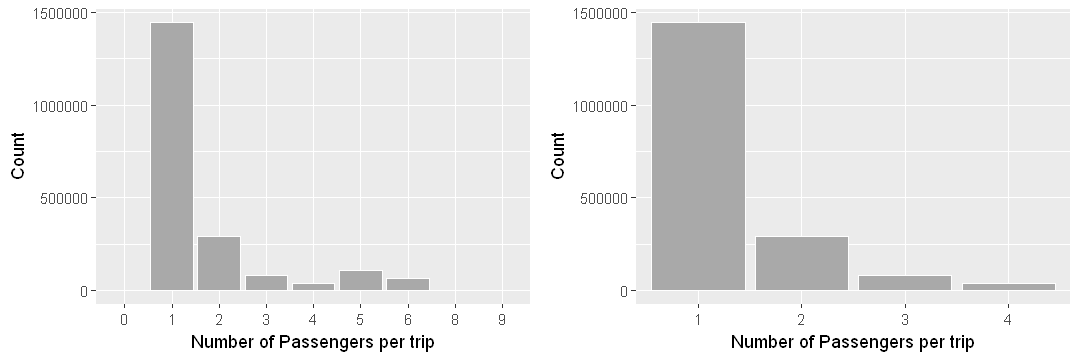

In [60]:
print(paste("Observations on data:",nrow(data)))

zeros <- data %>% filter(passenger_count==0)

print(paste("# of observations with passenger_count=0:",nrow(zeros)))

p1 <- ggplot(data, aes( x= passenger_count)) + 
    theme(axis.title = element_text(size=10.5)) +
    geom_bar(stat='Count', position='dodge',colour = "white", fill = "darkgray",) + 
    ylab("Count") + xlab("Number of Passengers per trip") +
    scale_y_continuous(labels = function(x) format(x, scientific = FALSE))

data <-data %>%
     mutate(passenger_count=replace(passenger_count, passenger_count==0, 1))  %>% 
     filter(passenger_count %in% c(1,2,3,4))

p2 <- ggplot(data, aes( x= passenger_count)) + 
    theme(axis.title = element_text(size=10.5)) +
    geom_bar(stat='Count', position='dodge',colour = "white", fill = "darkgray",) + 
    ylab("Count") + xlab("Number of Passengers per trip") +
    scale_y_continuous(labels = function(x) format(x, scientific = FALSE))


options(repr.plot.width=9, repr.plot.height=3) #Graph sizing in jupyter,for rstudio is not required
layout <- matrix(c(1,2),1,2,byrow=TRUE)
multiplot(p1,p2, layout=layout)

print(paste("Observations on data:",nrow(data)))

## 3.5 distance
Given the pickup/dropoff coordinates, it is possible to estimate the "as the crow flies" distance for each taxi trip. It is certain that taxis does not fly as crows, however it brings us an idea of how far each taxi goes. In addition the variable speed will be introduced which will bring us an idea of how fast each taxi trip went compared with another one. 

[1] "Observations on data: 1860410"


[1] "Observations on data: 1822587"


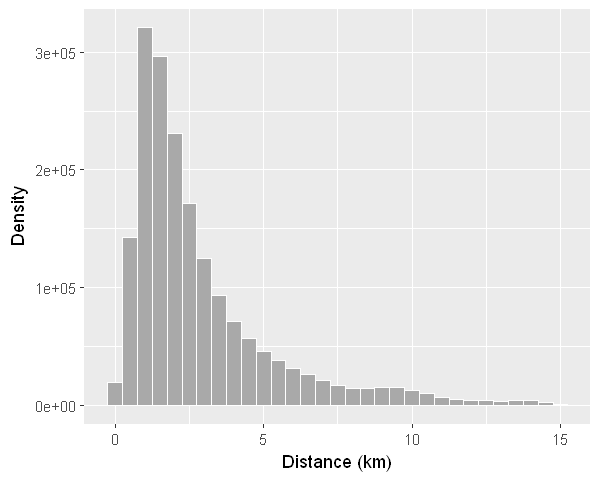

In [61]:
print(paste("Observations on data:",nrow(data)))

data$dist <- round(distCosine(data[c("pickup_longitude","pickup_latitude")],data[c("dropoff_longitude","dropoff_latitude")])/1000,2)

data <-data %>%
     filter(dist < 15)

options(repr.plot.width=5, repr.plot.height=4) #Graph sizing in jupyter,for rstudio is not required

ggplot(data, aes(dist)) + 
    theme(legend.position = "none",axis.title = element_text(size=10.5)) + 
    geom_histogram(colour = "white", fill = "darkgray", binwidth = .5) + 
    labs(x = "Distance (km)", y = "Density") 

print(paste("Observations on data:",nrow(data)))

## 3.6 Speed

[1] "Max speed 357 km/h"
[1] "Observations on data: 1822587"
[1] "# of observations with speed<60: 2648"


Warning message:
"Removed 552930 rows containing non-finite values (stat_bin)."

[1] "Observations on data: 1815361"


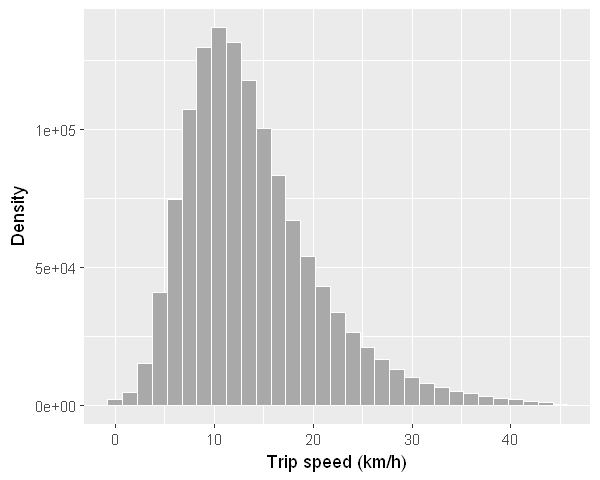

In [62]:
data$speed <-round(data$dist/(data$trip_duration/3600),2)

print(paste("Max speed",round(max((data %>% filter(dataset=="train"))$speed),2),"km/h"))
print(paste("Observations on data:",nrow(data)))
print(paste("# of observations with speed<60:",nrow(data %>% filter (speed>45 & dataset=="train"))))

data <-data %>% 
           filter ((speed<45 & speed > 0.1) | dataset=="test")

options(repr.plot.width=5, repr.plot.height=4) #Graph sizing in jupyter,for rstudio is not required

ggplot(data, aes(speed)) + 
    theme(legend.position = "none", axis.title = element_text(size=10.5)) + 
    geom_histogram(colour = "white", fill = "darkgray", binwidth = 1.5) + 
    labs(x = "Trip speed (km/h)", y = "Density") 

print(paste("Observations on data:",nrow(data)))

## 3.6 Date and time

In [63]:
print(paste("Observations on data:",nrow(data)))

# Create the hour, min, weekday and weekend variables
data <- data %>%
  mutate(date         = date(pickup_datetime),
         hour         = hour(pickup_datetime),
         weekday      = lubridate::wday(pickup_datetime, label=TRUE),
         weekend      = is.weekend(pickup_datetime),
         month        = month(pickup_datetime, label = TRUE, abbr = FALSE))   %>% 
         select (-c(pickup_datetime))

#create the holiday varible
data$holiday <- rep("notHoliday",nrow(data))

#Summer holidays
data[data$date > "2016-06-06" & data$pickup_datetime < "2016-09-05","holiday"] <- "school"

#national Holidays
national <- as.Date(c("2016-01-01","2016-01-18","2016-05-30"))
civic <- as.Date(c("2016-02-16","2016-05-08","2016-06-19"))

data[data$date %in% national,"holiday"] <- "national"
data[data$date %in% civic,"holiday"] <- "civic"

#convert the field to factor
data <- data %>%
  mutate_at("holiday", funs(factor)) 

data %>% 
  group_by(holiday) %>% 
  filter(dataset=="train") %>% 
  summarise (mean(trip_duration))

print(paste("Observations on data:",nrow(data)))

[1] "Observations on data: 1815361"


holiday,mean(trip_duration)
civic,713.4599
national,641.6686
notHoliday,759.4925


[1] "Observations on data: 1815361"


# 4. Weather

In [64]:
weather <- fread('C:/datasets/NYCtaxi_weather.csv', sep=",", stringsAsFactors=F)

weather <- weather %>%
    mutate_at("date", funs(dmy))  %>% 
    mutate(precipitation=replace(precipitation, precipitation=="T", "0.0"))  %>% 
    mutate(snowfall=replace(snowfall, snowfall=="T", "0.0"))  %>% 
    mutate(snowdepth=replace(snowdepth, snowdepth=="T", "0.0"))  %>% 
    mutate_at("precipitation", funs(as.numeric))  %>% 
    mutate_at("snowfall", funs(as.numeric))  %>% 
    mutate_at("snowdepth", funs(as.numeric))  %>% 
    mutate(maxTemp = round((maxTemp - 32) * (5/9),0),
           minTemp = round((minTemp - 32) * (5/9),0),
           avgTemp = round((avgTemp - 32) * (5/9),0),
           precipitation = round(precipitation * 2.54,1),
           snowfall = round(snowfall * 2.54,1),
           snowdepth = round(snowdepth * 2.54,1))


data <- left_join(data, weather, by = "date")


# 5. Save cleaned data

In [65]:
str(data)

'data.frame':	1815361 obs. of  25 variables:
 $ passenger_count     : Factor w/ 10 levels "0","1","2","3",..: 2 2 2 2 2 5 2 2 2 5 ...
 $ pickup_longitude    : num  -74 -74 -74 -74 -74 ...
 $ pickup_latitude     : num  40.8 40.7 40.8 40.7 40.8 ...
 $ pickup_county       : Factor w/ 5 levels "Bronx","Hudson",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ dropoff_longitude   : num  -74 -74 -74 -74 -74 ...
 $ dropoff_latitude    : num  40.8 40.7 40.7 40.7 40.8 ...
 $ dropoff_county      : Factor w/ 5 levels "Bronx","Hudson",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ trip_duration       : int  455 663 2124 429 435 341 255 1225 1274 1128 ...
 $ dataset             : chr  "train" "train" "train" "train" ...
 $ pickup_neighborhood : Factor w/ 559 levels "19th Ward","Abbott McKinley",..: 317 203 317 499 513 486 220 203 317 191 ...
 $ dropoff_neighborhood: Factor w/ 559 levels "19th Ward","Abbott McKinley",..: 509 220 167 167 513 509 146 513 220 509 ...
 $ dist                : num  1.5 1.81 6.39 1.49 1.19 1.33 1.31 5.13 3

In [66]:
write.table(data, "C:/datasets/NYCtaxi_cleaned_data.csv", sep=",", dec=".", quote=FALSE, row.names=FALSE)